# TP 1 - Introducción al aprendizaje automatizado
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [17]:
# Imports iniciales
%matplotlib inline
from common import *
from tree import *

--------------------------------------------------------------------------------
## Ejercicio 1

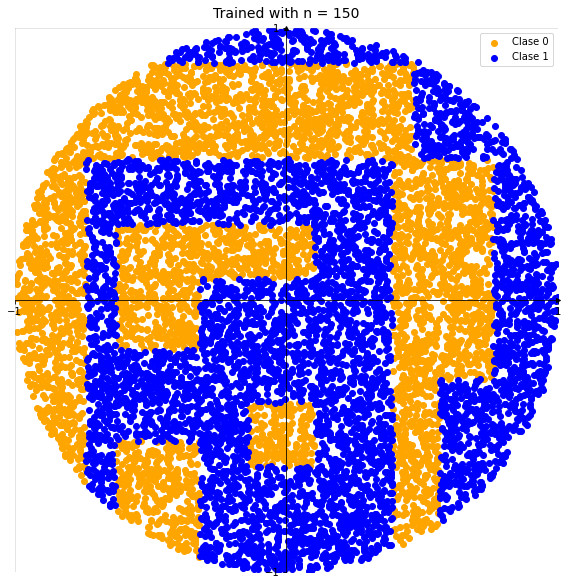

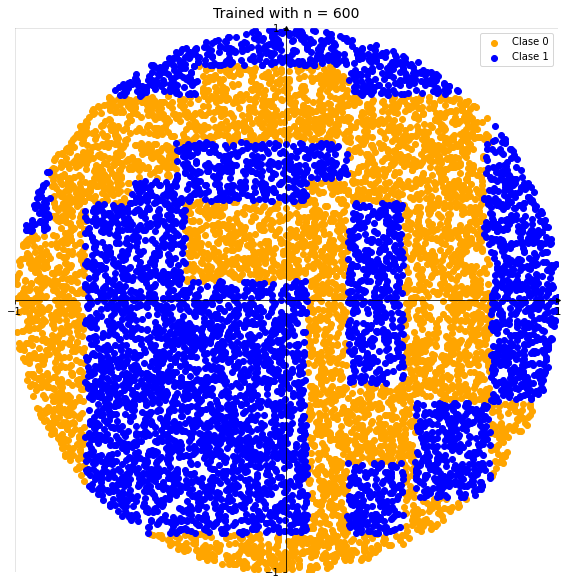

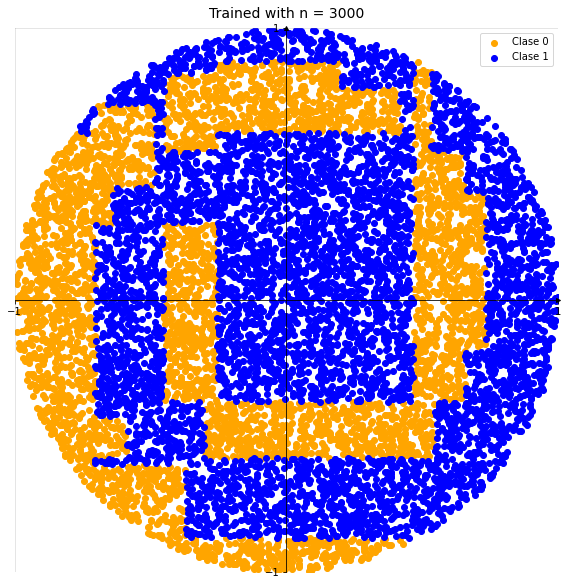

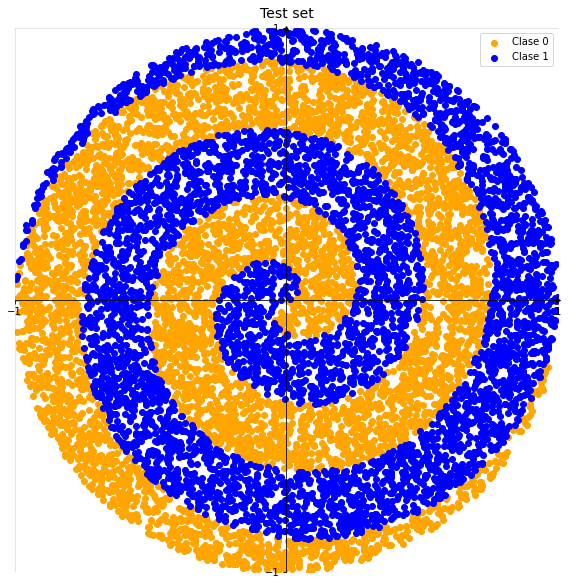

In [18]:
# Ejercicio 1
# Genero los datos de entrenamiento
df_train_spirals_150 = generate_spirals(150)
df_train_spirals_600 = generate_spirals(600)
df_train_spirals_3000 = generate_spirals(3000)
# Genero el conjunto de test
df_test_spirals_10000 = generate_spirals(10000)

# Entreno los árboles correspondientes
clf_spiral_150 = train_tree(df_train_spirals_150)
clf_spiral_600 = train_tree(df_train_spirals_600)
clf_spiral_3000 = train_tree(df_train_spirals_3000)

# Predigo
predict_spiral_150 = predict_tree(df_test_spirals_10000, clf_spiral_150)
predict_spiral_600 = predict_tree(df_test_spirals_10000, clf_spiral_600)
predict_spiral_3000 = predict_tree(df_test_spirals_10000, clf_spiral_3000)

# Grafico los resultados de las predicciones
graph_df(predict_spiral_150, "Trained with n = 150")
graph_df(predict_spiral_600, "Trained with n = 600")
graph_df(predict_spiral_3000, "Trained with n = 3000")
# También grafico el conjunto de test original para comparar los resultados con lo esperado
graph_df(df_test_spirals_10000, "Test set")

### Conclusiones
En el gráfico obtenido para n = 150 se puede ver que los puntos se clasifican
en su mayoría de forma incorrecta y las formas del gráfico están muy lejos
de las espirales esperadas.

Para n = 600 y n = 3000 los gráficos se asemejan un poco más a lo esperado pero
igualmente los resultados no son satisfactorios.

A partir de esto puedo concluir que para este problema se deberían usar conjuntos
de entrenamiento de mayor tamaño para obtener mejores resultados.


--------------------------------------------------------------------------------
## Ejercicio 2

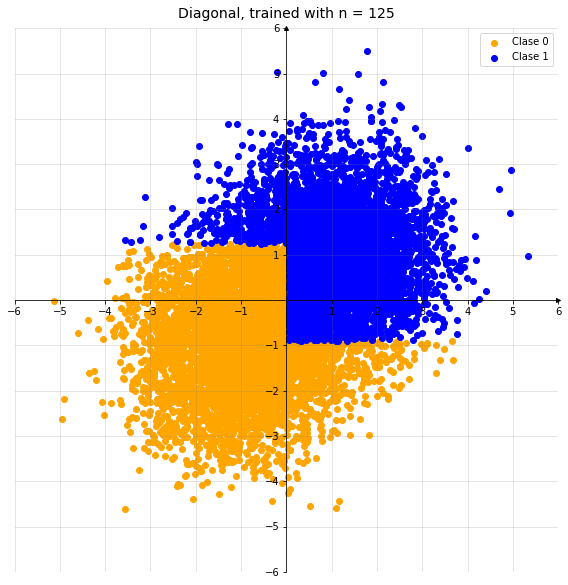

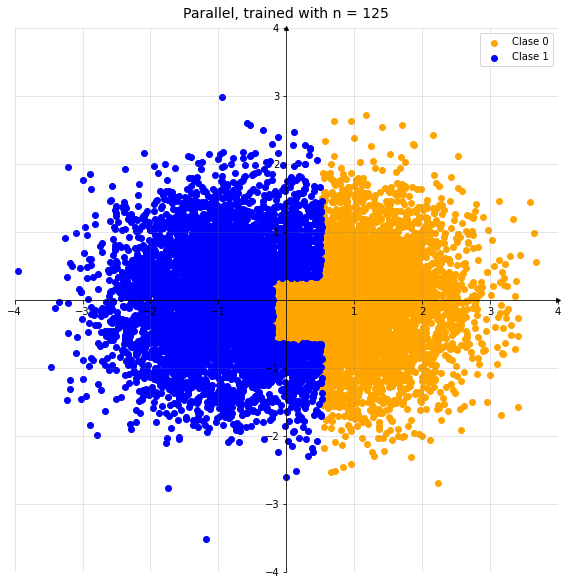

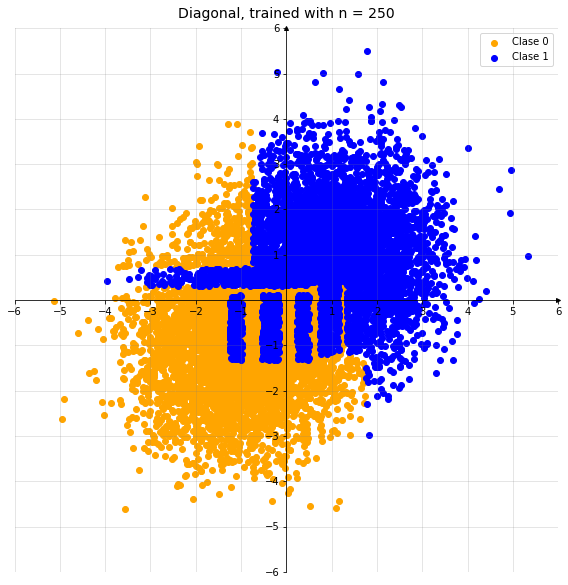

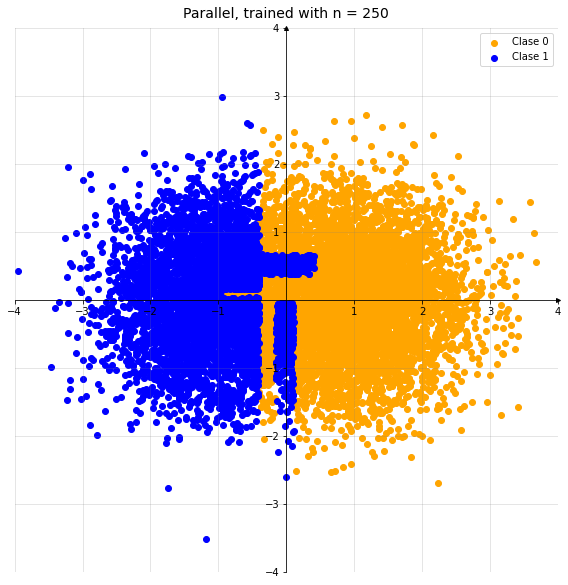

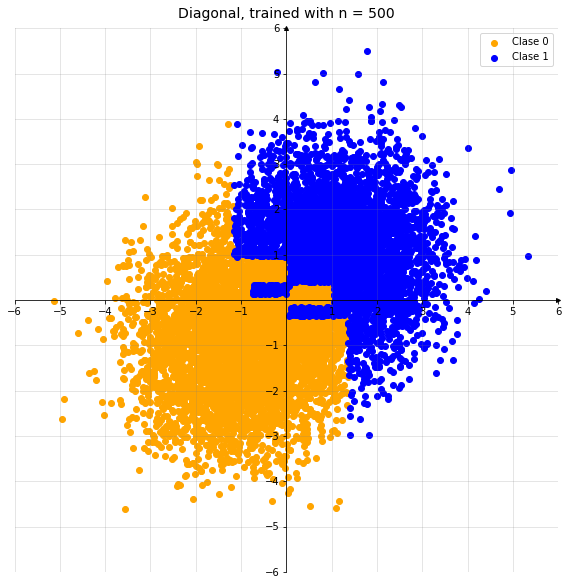

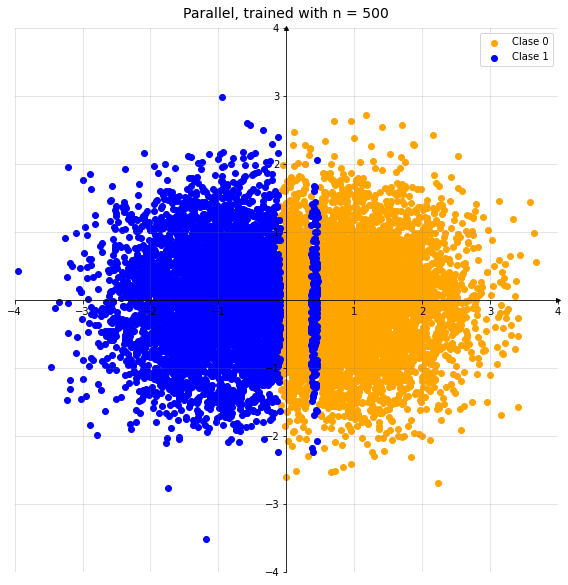

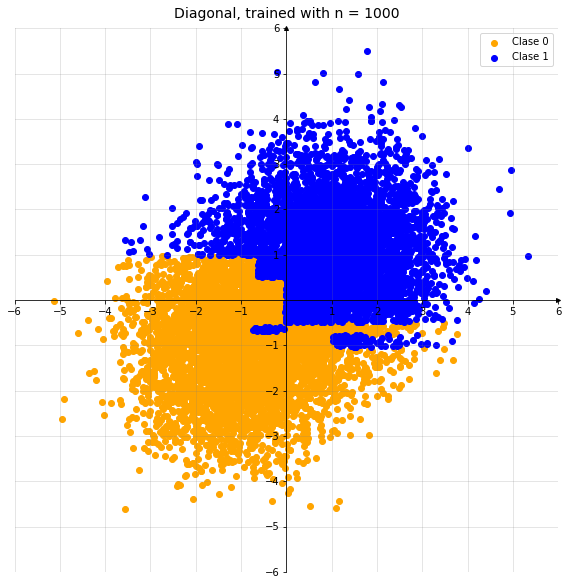

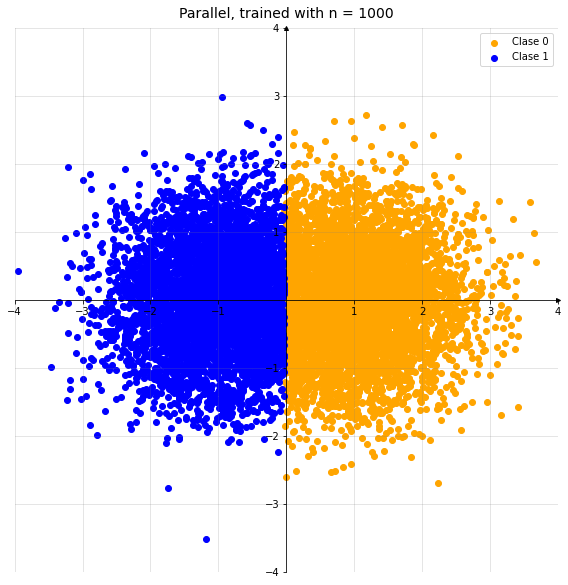

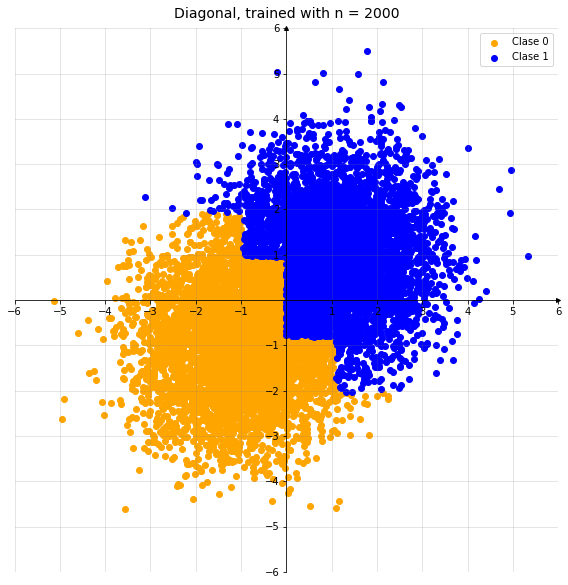

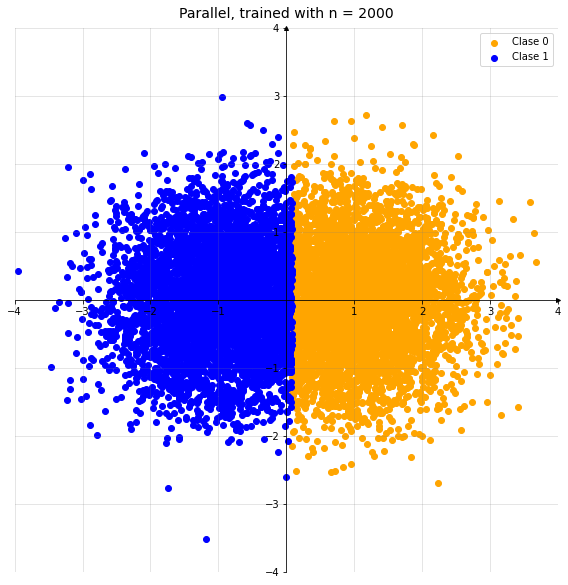

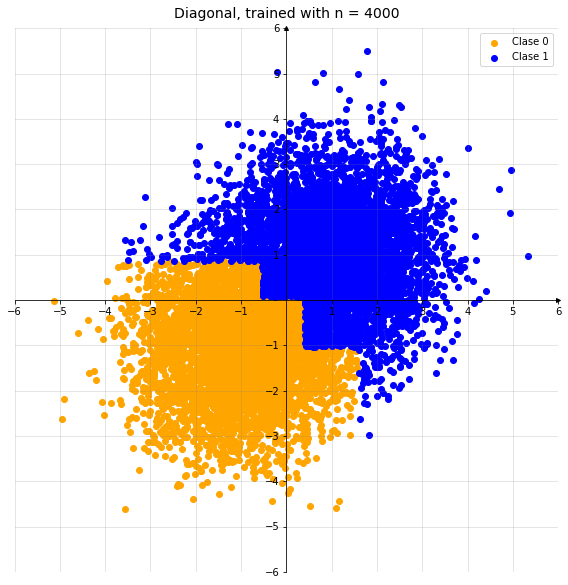

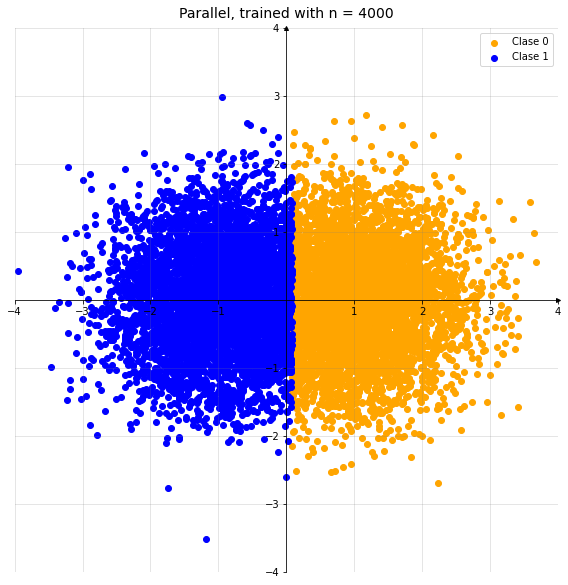

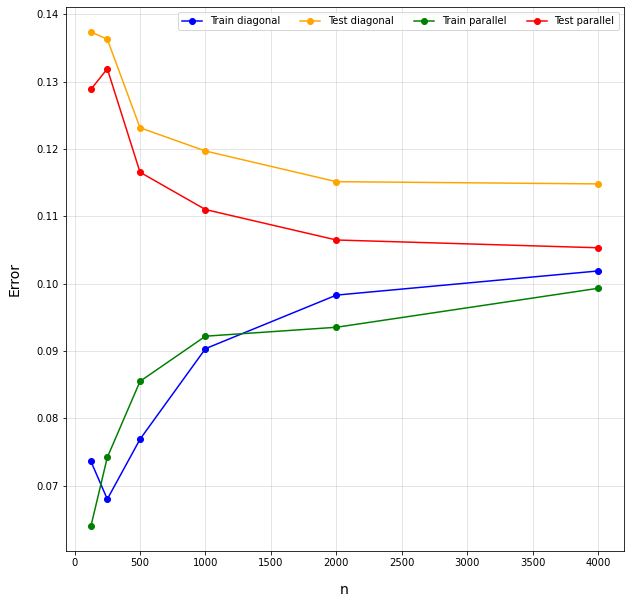

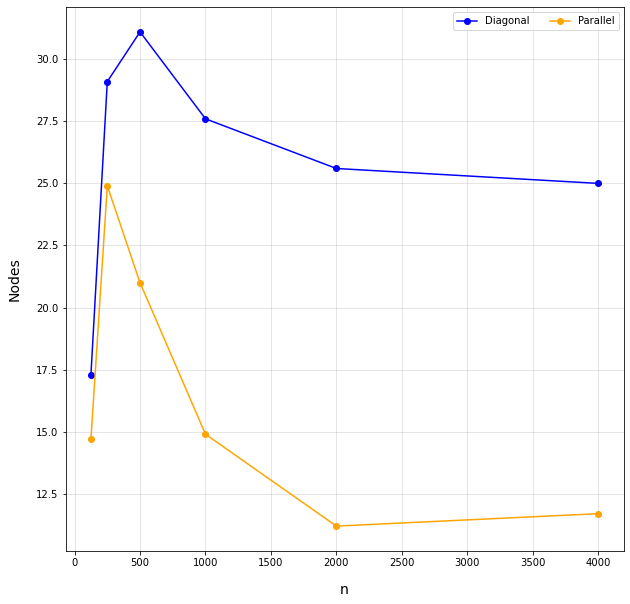

In [19]:
# Genero los conjuntos de test para los problemas de diagonal y paralelo con n = 100000
df_test_diagonal_10000 = generate_diagonal(2, 10000, 0.78)
df_test_parallel_10000 = generate_parallel(2, 10000, 0.78)

# Valores de n utilizados para generar los conjuntos de entrenamientos
n_points = [125, 250, 500, 1000, 2000, 4000]

# Listas para acumular los datos obtenidos más abajo
errors = []
nodes_counts = []

for n in n_points:
  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(2, n, 0.78)
    df_train_para = generate_parallel(2, n, 0.78)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_tree(df_train_diag, clf_diag)
    predict_test_diag = predict_tree(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_tree(df_train_para, clf_para)
    predict_test_para = predict_tree(df_test_parallel_10000, clf_para)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), n, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), n, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), n, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), n, "Test parallel"])

    # Calculo la cuenta de nodos para el arbol
    nodes_counts.append([clf_diag.tree_.node_count, n, "Diagonal"])
    nodes_counts.append([clf_para.tree_.node_count, n, "Parallel"])

  # Grafico fuera del loop sobre i para graficar solo los últimos resultados de cada n
  graph_df(predict_test_diag, "Diagonal, trained with n = " + str(n))
  graph_df(predict_test_para, "Parallel, trained with n = " + str(n))

# Creo los dataframes con los errores y conteos de nodos
ej2_errors_df = pd.DataFrame(errors, columns = ["Error", "n", "Class"])
ej2_nodes_counts_df = pd.DataFrame(nodes_counts, columns = ["Nodes", "n", "Class"])

# Grafico los datos obtenidos sobre los errores y los conteos de nodos
graph_errors(ej2_errors_df, 'n')
graph_nodes_count(ej2_nodes_counts_df)

### Conclusiones

Para los problemas "diagonal" y "paralelo" los resultados son satisfactorios
a partir de n = 2000, en la gráfica con los errores se puede ver como a partir
de n = 2000 no obtenemos una disminución significativa del error al aumentar el tamaño
del conjunto del entrenamiento y los árboles no aumentan su tamaño tampoco. 
Por lo que con un conjunto de entrenamiento de tamaño 2000 es suficiente.

Otro detalle a notar en el gráfico de tamaño de los árboles es como para n = 250
la cantidad de nodos para cada árbol se dispara y luego al crecer n los árboles van disminuyendo
su tamaño hasta estabilizarse a partir de n = 2000, esto probablemente sea a causa
de un overfitting con un conjunto de entrenamiento pequeño.

--------------------------------------------------------------------------------

## Ejercicio 3 y opcional 3.1
Para realizar el ejercicio opcional primero defino estas funciones que luego usaré para presentar los datos pedidos junto a los datos obtenidos del ejercicio 3.

Como clasificador ideal se me ocurrió utilizar una función que clasifique los puntos según sus distancia a los centros de origen al generar los mismos.
Por ejemplo para el problema "diagonal", si tengo un punto cuya distancia al punto (1, 1, 1, ..., 1) es menor que su distancia al punto (-1, -1, -1, ..., -1) es más probable que pertenezca a la clase 1, por lo que lo clasifico de esa forma.

In [20]:
# Función definida como clasificador de mínimo error
# Recibe un dataframe y dos centros, para cada punto si
# se encuentra más cerca del center0 que del center1 lo clasifica
# en la clase 0 y viceversa.
def optimal_classifier(df_test, center0, center1):
  # Copio el dataframe original para no modificarlo
  df_optimal = df_test.copy(deep = True)
  # Obtengo la lista de puntos
  points_list = df_test.drop('Class', axis = 1).values.tolist()

  classes = []

  center0 = np.array(center0)
  center1 = np.array(center1)

  for point in [np.array(p) for p in points_list]:
    # Para cada punto obtengo la distancia a los centros dados
    distance0 = np.sqrt(np.sum(np.square(point - center0)))
    distance1 = np.sqrt(np.sum(np.square(point - center1)))

    # Y los clasifico según su cercanía
    if distance0 <= distance1:
      classes.append(0)
    else:
      classes.append(1)

  df_optimal['Class'] = classes

  return df_optimal

# Clasificador ideal para el problema "diagonal"
def optimal_diagonal(df_test):
  d = len(df_test.columns) - 1
  center0 = [-1] * d
  center1 = [1] * d
  return optimal_classifier(df_test, center0, center1)

# Clasificador ideal para el problema "paralelo"
def optimal_parallel(df_test):
  d = len(df_test.columns) - 1
  center0 = [1] + ([0] * (d - 1))
  center1 = [-1] + ([0] * (d - 1))
  return optimal_classifier(df_test, center0, center1)

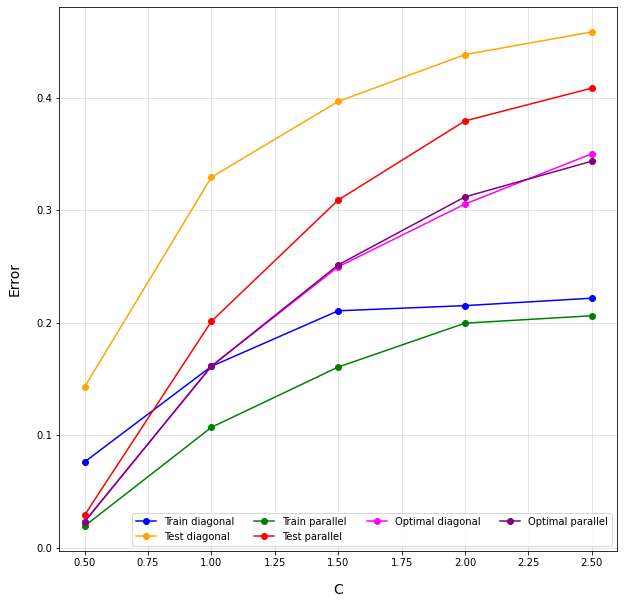

In [21]:
errors = []
nodes_counts = []

for C in np.arange(0.5, 3, 0.5):
  # Genero los conjuntos de test para cada C
  df_test_diagonal_10000 = generate_diagonal(5, 10000, C)
  df_test_parallel_10000 = generate_parallel(5, 10000, C)

  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(5, 250, C)
    df_train_para = generate_parallel(5, 250, C)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_tree(df_train_diag, clf_diag)
    predict_test_diag = predict_tree(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_tree(df_train_para, clf_para)
    predict_test_para = predict_tree(df_test_parallel_10000, clf_para)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), C, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), C, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), C, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), C, "Test parallel"])   

  # Clasifico con el clasificador de Bayes para cada conjunto de test para cada C
  optimal_diag = optimal_diagonal(df_test_diagonal_10000)
  optimal_para = optimal_parallel(df_test_parallel_10000)

  # Calculo los errores mínimos
  errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], optimal_diag['Class']), C, "Optimal diagonal"])
  errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], optimal_para['Class']), C, "Optimal parallel"])

# Creo el dataframes con los errores
ej3_errors_df = pd.DataFrame(errors, columns = ["Error", "C", "Class"])

# Grafico los errores
graph_errors(ej3_errors_df, 'C')

### Conclusiones
En la gráfica se puede observar como al aumentar el valor C los puntos de las diferentes
clases se solapan cada vez más entre sí, aumentando el ruido en los datos de los
conjuntos de entrenamiento y provocando que sea cada vez más dificil clasificarlos,
incrementando el error a medida que incrementa el valor de C.

Los clasificadores ideales definidos anteriormente tienen un error menor
pero igualmente alto, probablemente debido al overlapping de las clases, por lo que
no son inmunes al ruido.

Otra cosa a notar es que este modelo es menos preciso con el problema "diagonal"
que con el problema "paralelo".

--------------------------------------------------------------------------------
## Ejercicio 4

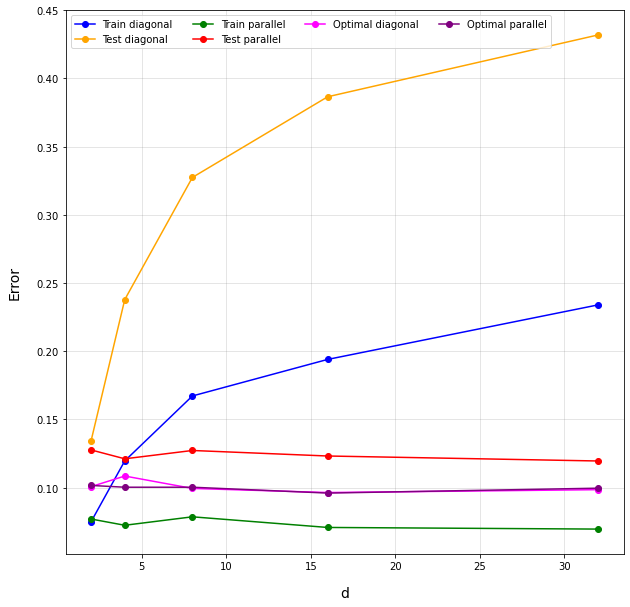

In [22]:
errors = []

for d in [2 ** i for i in range(1, 6)]:
  # Genero los conjuntos de test para cada d
  df_test_diagonal_10000 = generate_diagonal(d, 10000, 0.78)
  df_test_parallel_10000 = generate_parallel(d, 10000, 0.78)

  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(d, 250, 0.78)
    df_train_para = generate_parallel(d, 250, 0.78)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_tree(df_train_diag, clf_diag)
    predict_test_diag = predict_tree(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_tree(df_train_para, clf_para)
    predict_test_para = predict_tree(df_test_parallel_10000, clf_para)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), d, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), d, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), d, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), d, "Test parallel"])
  
  # Clasifico con el clasificador de Bayes para cada conjunto de test para cada d
  optimal_diag = optimal_diagonal(df_test_diagonal_10000)
  optimal_para = optimal_parallel(df_test_parallel_10000)

  # Calculo los errores mínimos
  errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], optimal_diag['Class']), d, "Optimal diagonal"])
  errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], optimal_para['Class']), d, "Optimal parallel"])

# Creo el dataframes con los errores
ej4_errors_df = pd.DataFrame(errors, columns = ["Error", "d", "Class"])

# Grafico los errores obtenidos
graph_errors(ej4_errors_df, "d")

### Conclusiones
De forma similar a los resultados obtenidos en el ejercicio anterior, el problema
de clasificar los puntos se vuelve más difícil al aumentar la dimensionalidad de los puntos,
probablemente porque al tener más coordenadas para generar por cada punto existe una mayor probabilidad
de insertar ruido en los datos. Nuevamente el problema "diagonal" tiene un error
mayor al clasificar que el problema "paralelo".

Por curiosidad, volví a utilizar los clasificadores de error mínimo del ejercicio
anterior, estos mismos obtuvieron un error mucho menor al error de la clasificación
mediante los árboles de decisión.

--------------------------------------------------------------------------------
## Ejercicio 5

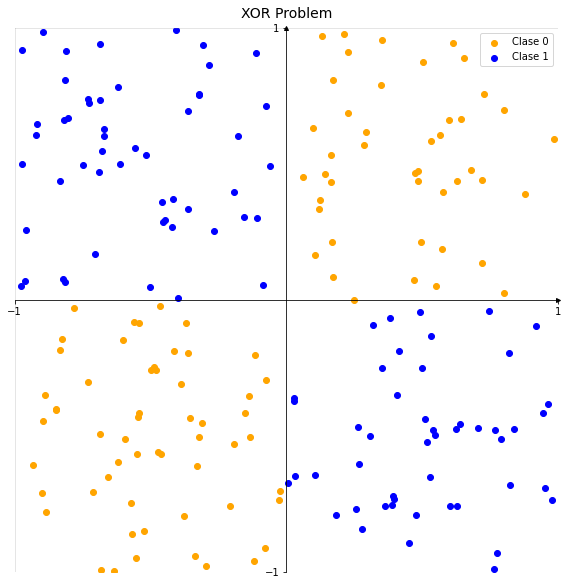

In [23]:
# Leo los datos desde el archivo dado
df_xor = pd.read_csv("xor.csv", header=None, names=[0, 1, 'Class'])
# Grafico los puntos
graph_df(df_xor, "XOR Problem")

En este problema los puntos cuyas ambas coordenadas x e y coincidan en sus signos
pertenecen a la clase 0, en caso contrario pertenecen a la clase 1.
Por ej: (1, 2), (-2, -2) pertenecen a la clase 0 y (1, -1), (-20, 7)
pertenecen a la clase 1.

A partir de estas propiedades puedo indicar el siguiente árbol simple que
clasifique correctamente todos los puntos:
![](./ej5simpletree.png)

Error de predecir sobre el árbol obtenido: 0.5


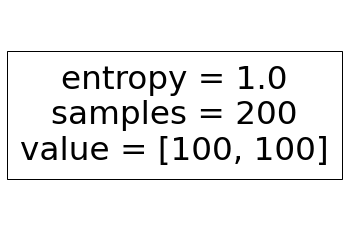

In [24]:
clf_xor = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.03,random_state=0,min_samples_leaf=5)
clf_xor.fit(df_xor[[0, 1]], df_xor['Class'])
tree.plot_tree(clf_xor)
predict_xor = predict_tree(df_xor, clf_xor)

print("Error de predecir sobre el árbol obtenido:", 1 - accuracy_score(df_xor['Class'], predict_xor['Class']))

### Conclusiones
El árbol obtenido es de un solo nodo con una entropía máxima de 1, por lo que
resulta totalmente inútil para clasificar datos de este problema.

Esto nos muestra que nuestro modelo no es el correcto para predecir sobre estos
problemas conocidos como "no-lineares".